# Import libraries

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
from scipy.spatial.distance import jensenshannon

from dataset.utils import show_image_grid
from dataset import AllCTsDataset


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Load correlation stats

In [3]:
gen_name = 'gen-05'
coeff_gen = np.load(f'../memorization/stats/{gen_name}-corr.npy')
max_idx = np.argmax(np.abs(coeff_gen), axis=1)
max_corr_gen = np.max(np.abs(coeff_gen), axis=1)
idx = np.abs(coeff_gen).argsort(axis=1)[:, -2]
second_max_corr_gen = np.abs(coeff_gen[np.arange(len(coeff_gen)), idx])
ratio_gen = second_max_corr_gen / max_corr_gen

In [4]:
train_dataset = AllCTsDataset(f'../data/allcts-global-128/', split='train')
gen_dataset = AllCTsDataset(f'../data/{gen_name}/', split='all')
gen_dataset.input_df['ratio'] = ratio_gen
gen_dataset.input_df['max_idx'] = max_idx
gen_dataset.input_df['max_corr'] = max_corr_gen
gen_df = gen_dataset.input_df
gen_df.head()

,name,split,quality,ratio,max_idx,max_corr
0,ctg_0_q2,train,2,0.863734,37,0.839212
1,ctg_1_q2,train,2,0.868922,274,0.846713
2,ctg_2_q2,train,2,0.942755,231,0.734619
3,ctg_3_q2,train,2,0.988276,116,0.755358
4,ctg_4_q2,train,2,0.994560,649,0.744571


# Finding copy features

In [5]:
gen_df['copy_name'] = train_dataset.input_df.iloc[max_idx].name.values
gen_df['copy_index'] = train_dataset.input_df.iloc[max_idx].index.values
gen_df['copy_qs'] = train_dataset.input_df.iloc[max_idx].quality.values
gen_df

,name,split,quality,ratio,max_idx,max_corr,copy_name,copy_index,copy_qs
0,ctg_0_q2,train,2,0.863734,37,0.839212,CTS053,50,2
1,ctg_1_q2,train,2,0.868922,274,0.846713,CTS364,337,2
2,ctg_2_q2,train,2,0.942755,231,0.734619,CTS307,284,2
3,ctg_3_q2,train,2,0.988276,116,0.755358,CTS146,140,2
4,ctg_4_q2,train,2,0.994560,649,0.744571,CT333,807,3
...,...,...,...,...,...,...,...,...,...
2995,ctg_639_q5,train,5,0.906438,437,0.791067,CTS567,539,5
2996,ctg_640_q5,train,5,0.961981,369,0.792118,CTS477,449,5
2997,ctg_641_q5,train,5,0.877956,383,0.748831,CTS495,467,5
2998,ctg_642_q5,train,5,0.865206,394,0.819066,CTS511,483,5


In [6]:
gen_df = gen_df.sort_values('ratio', ascending=True)
plot_df = gen_df.loc[gen_df['quality'] == 5]
plot_df = plot_df.drop_duplicates('copy_index')
plot_df

,name,split,quality,ratio,max_idx,max_corr,copy_name,copy_index,copy_qs
2941,ctg_585_q5,train,5,0.632505,7,0.926245,CTS012,12,5
2538,ctg_182_q5,train,5,0.638021,40,0.918707,CTS056,53,5
2884,ctg_528_q5,train,5,0.655079,12,0.928867,CTS020,20,5
2483,ctg_127_q5,train,5,0.659026,406,0.861728,CTS524,496,5
2938,ctg_582_q5,train,5,0.662092,433,0.862411,CTS563,535,5
...,...,...,...,...,...,...,...,...,...
2891,ctg_535_q5,train,5,0.992941,384,0.714257,CTS496,468,5
2566,ctg_210_q5,train,5,0.994921,715,0.711845,CT465,891,2
2545,ctg_189_q5,train,5,0.996930,489,0.754104,CT039,600,2
2567,ctg_211_q5,train,5,0.998811,454,0.658921,CTS588,560,6


# Picture of original and copy

In [7]:
c = 5

gen_images = []
train_images = []
gen_names = []
train_names = []


for i in range(c):
    index_name_gen = plot_df.index[i]
    index_gen = gen_dataset.df.index.get_loc(index_name_gen)
    gen_img = gen_dataset[index_gen]['data']
    gen_images.append(gen_img)
    gen_names.append(plot_df.name.iloc[i])
    
    index_name_train = plot_df.copy_index.iloc[i]
    index_train = train_dataset.df.index.get_loc(index_name_train)
    train_img = train_dataset[index_train]['data']
    train_images.append(train_img)
    train_names.append(plot_df.copy_name.iloc[i])


In [10]:
gen_images = [image.detach().cpu().numpy() for image in gen_images]
train_images = [image.detach().cpu().numpy() for image in train_images]

In [11]:
# Remove channel and batch dimensions if present and rotate images
gen_images = [np.rot90(np.squeeze(image), k=1, axes=(0, 2)) for image in gen_images]
train_images = [np.rot90(np.squeeze(image), k=1, axes=(0, 2)) for image in train_images]

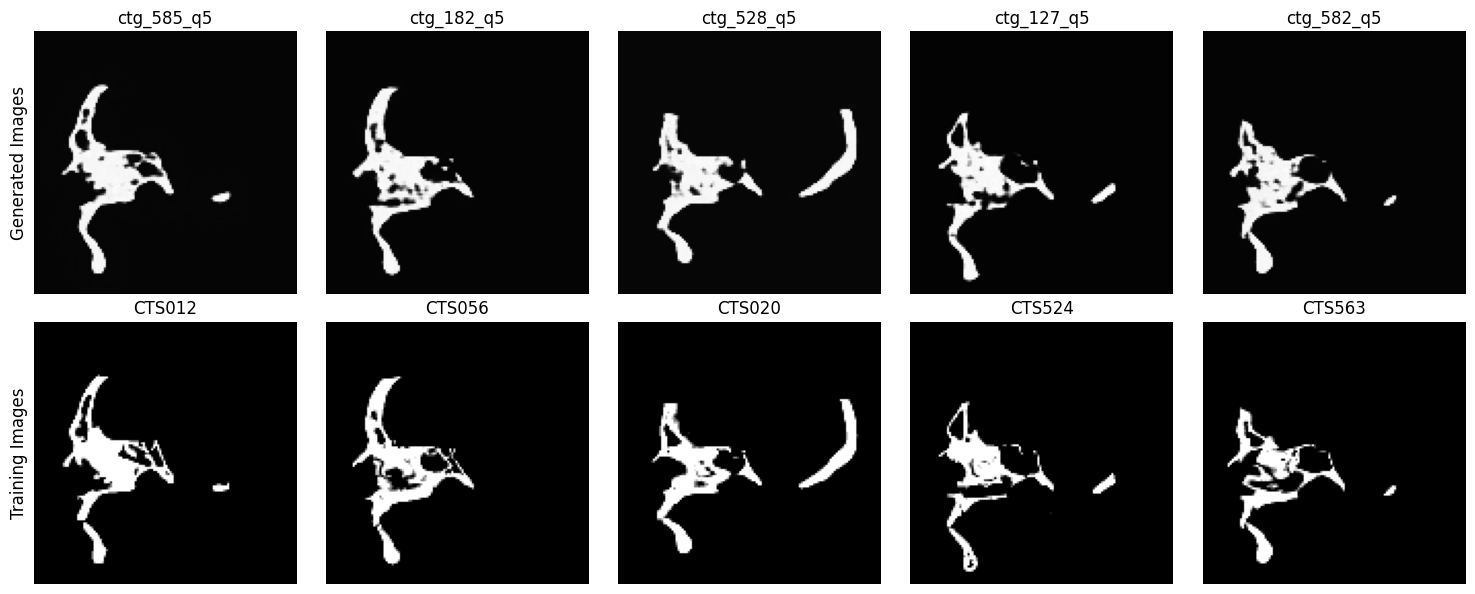

In [18]:
import matplotlib.pyplot as plt

# Determine the middle slice index
middle_slice_index = gen_images[0].shape[1] // 2

# Create a new figure
fig, axes = plt.subplots(2, c, figsize=(15, 6))

for i in range(c):
    # Plot the middle slice of the generated image
    axes[0, i].imshow(gen_images[i][:, middle_slice_index, :], cmap='gray')
    axes[0, i].set_title(gen_names[i])
    
    # Plot the middle slice of the training image
    axes[1, i].imshow(train_images[i][:, middle_slice_index, :], cmap='gray')
    axes[1, i].set_title(train_names[i])
    
    axes[0, i].xaxis.set_visible(False)
    axes[1, i].xaxis.set_visible(False)
    
    plt.setp(axes[0, i].spines.values(), visible=False)
    plt.setp(axes[1, i].spines.values(), visible=False)
    
    axes[0, i].tick_params(left=False, labelleft=False)
    axes[1, i].tick_params(left=False, labelleft=False)

# Add titles to the rows
axes[0, 0].set_ylabel('Generated Images', size='large')
axes[1, 0].set_ylabel('Training Images', size='large')

# Display the figure
plt.tight_layout()
plt.show()